# Spotify Recommendation System
**Author: Daniel Hassler**

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Data Analysis
Look at -> 
* https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb
* https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/code

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


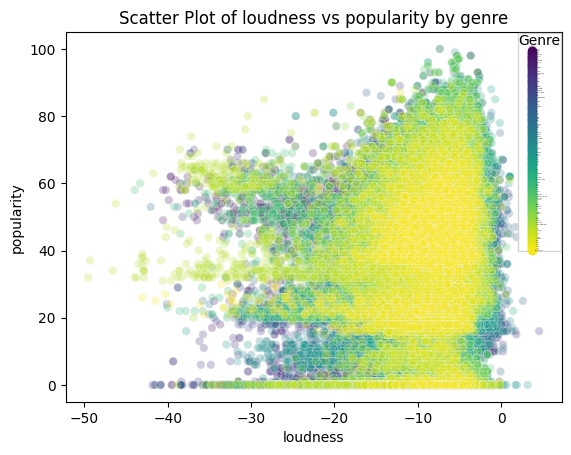

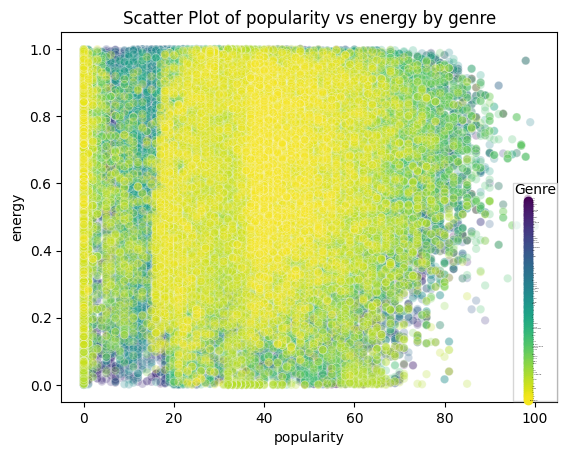

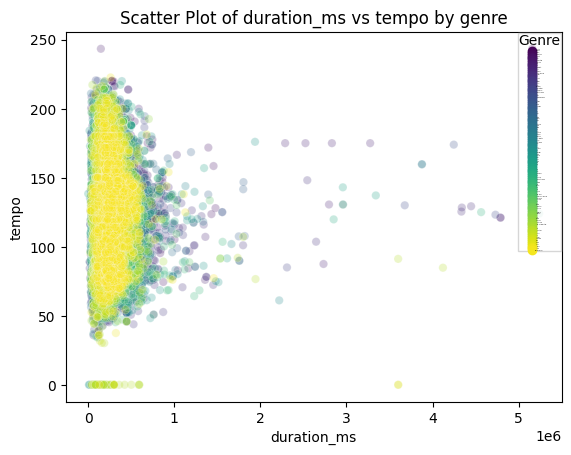

In [50]:
original_df = pd.read_csv("./dataset.csv")
print(original_df.columns)
features_x = ["loudness", "popularity", "duration_ms"]
features_y = ["popularity", "energy", "tempo"]

for i, (x,y) in enumerate(zip(features_x, features_y)):
    scatter = sns.scatterplot(x=x, y=y, hue='track_genre', data=original_df, palette="viridis", alpha=0.25)
    legend_labels = original_df['track_genre'].unique()# [:3]  # Show only the first 3 genres
    scatter.legend(title='Genre', labels=legend_labels, prop={'size': 1})
    plt.title(f"Scatter Plot of {x} vs {y} by genre")
    plt.show()

plt.show()

## K-Means Clustering

### Hyperparameter Tuning for K-Means

In [51]:
inertia = []
# train_df is the numeric representation of original_df
train_df = original_df.drop(columns=['Unnamed: 0', 'track_id', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'])

for col in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[col]):
        train_df[col] = pd.factorize(original_df[col])[0]

scaler = StandardScaler()
# df_scaled is the scaled version of train_df
df_scaled = scaler.fit_transform(train_df)
pca_num_components = 2

# df_pca to reduce dimensionality
pca = PCA(n_components=pca_num_components).fit_transform(df_scaled)
df_pca = pd.DataFrame(pca,columns=['pca1','pca2'])

for k in range(1, 80, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(df_pca)
    inertia.append(kmeans.inertia_)

d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

### Plotting the Elbow Chart

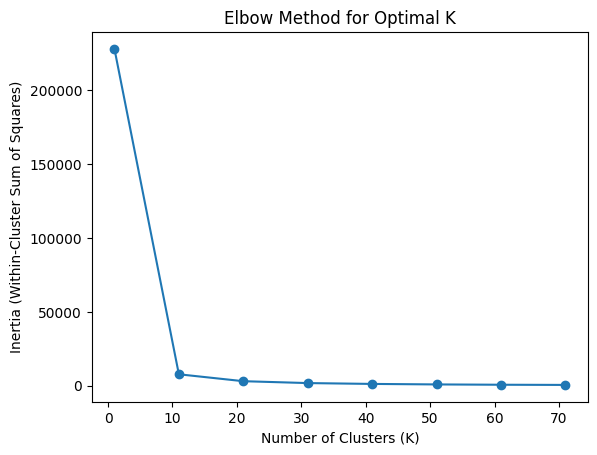

In [52]:
# Plot the elbow curve
plt.plot(range(1, 80, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()

### Choosing K-Means with "Elbow" Point

In [53]:
kmeans = KMeans(n_clusters=10, random_state=42)
original_df['clusters'] = kmeans.fit_predict(df_pca)

d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


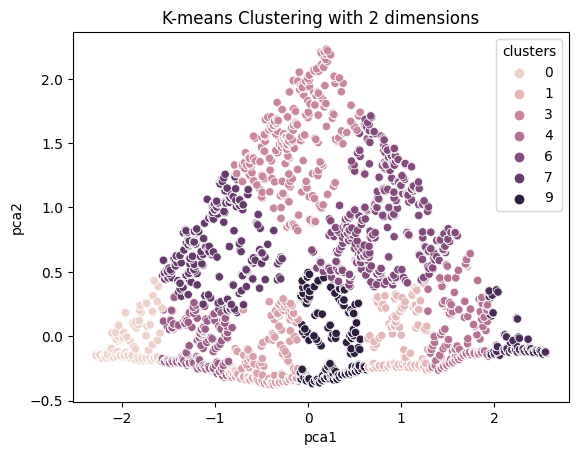

In [54]:
sns.scatterplot(x="pca1", y="pca2", hue=original_df['clusters'], data=df_pca)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

## Evaluation

In [58]:
original_df['Distance_to_Centroid'] = kmeans.transform(df_pca).min(axis=1)

In [59]:
def get_nearest_entry(idx, k=5):
    # print(original_df.iloc[idx])
    # print(train_df.iloc[idx])
    cluster = kmeans.predict(df_pca.iloc[idx].to_frame().T)[0]
    cluster_data = original_df[original_df["clusters"] == cluster]
    cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
    cluster_data = cluster_data.sort_values(by="closest_entries_to_idx")
    # print(cluster_data[["artists", "album_name", "track_name", "track_genre"]])

    cluster_data.drop(columns=["closest_entries_to_idx"])
    print(f"Top {k} Closest Examples to {cluster_data.loc[idx]['artists']}'s \"{cluster_data.loc[idx]['track_name']}\"")
    print(cluster_data[:k][["artists", "album_name", "track_name", "track_genre"]])
    print("\n\n")

get_nearest_entry(44151) # rock song
get_nearest_entry(19015) # country song
get_nearest_entry(51136) # rap song

Top 5 Closest Examples to Daughtry's "Home"
        artists                          album_name      track_name  \
44415  Daughtry           Baptized (Deluxe Version)     Battleships   
44457  Daughtry    It's Not Over....The Hits So Far     No Surprise   
44562  Daughtry    It's Not Over....The Hits So Far  Life After You   
44563  Daughtry  Break The Spell (Expanded Edition)   Gone Too Soon   
44709  Daughtry           Baptized (Deluxe Version)      I'll Fight   

      track_genre  
44415      grunge  
44457      grunge  
44562      grunge  
44563      grunge  
44709      grunge  



Top 5 Closest Examples to Florida Georgia Line's "Stay"
                    artists                 album_name         track_name  \
19027  Florida Georgia Line                Country USA  I Love My Country   
19761  Florida Georgia Line                       Life               Life   
19773  Florida Georgia Line  Can't Say I Ain't Country             Simple   
19015  Florida Georgia Line          Sad C

C:\Users\dwh71\AppData\Local\Temp\ipykernel_7112\4230517888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppData\Local\Temp\ipykernel_7112\4230517888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppDa